In [89]:
import math
import numpy as np
from collections import defaultdict

class QLearning(object):
    def __init__(self,n_states,
                 n_actions,cfg):
        self.n_actions = n_actions
        self.lr = cfg.lr  # 学习率
        self.gamma = cfg.gamma
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table  = defaultdict(lambda: np.zeros(n_actions)) # 用嵌套字典存放状态->动作->状态-动作值（Q值）的映射，即Q表
    def sample_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay) # epsilon是会递减的，这里选择指数递减
        # e-greedy 策略
        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)]) # 选择Q(s,a)最大对应的动作
        else:
            action = np.random.choice(self.n_actions) # 随机选择动作
        return action
    def predict_action(self,state):
        action = np.argmax(self.Q_table[str(state)])
        return action
    def update(self, state, action, reward, next_state, done):
        Q_predict = self.Q_table[str(state)][action]
        if done: # 终止状态
            Q_target = reward
        else:
            Q_target = reward + self.gamma * np.max(self.Q_table[str(next_state)])
        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

class SARSA(object):
    def __init__(self, n_states, n_actions, cfg):
        self.n_actions = n_actions
        self.lr = cfg.lr
        self.gamma = cfg.gamma
        self.epsilon = cfg.epsilon_start
        self.sample_count = 0
        self.epsilon_start = cfg.epsilon_start
        self.epsilon_end = cfg.epsilon_end
        self.epsilon_decay = cfg.epsilon_decay
        self.Q_table = defaultdict(lambda: np.zeros(n_actions))

    def sample_action(self, state):
        self.sample_count += 1
        self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.sample_count / self.epsilon_decay)

        if np.random.uniform(0, 1) > self.epsilon:
            action = np.argmax(self.Q_table[str(state)])
        else:
            action = np.random.choice(self.n_actions)
        return action

    def predict_action(self, state):
        action = np.argmax(self.Q_table[str(state)])
        return action

    def update(self, state, action, reward, next_state, next_action, done):
        Q_predict = self.Q_table[str(state)][action]
        if done:
            Q_target = reward
        else:
            # 区别：这里使用的是 next_action 的 Q 值，而不是 max Q
            Q_target = reward + self.gamma * self.Q_table[str(next_state)][next_action]

        self.Q_table[str(state)][action] += self.lr * (Q_target - Q_predict)

In [90]:
def train_Qlearning(cfg,env,agent):
    print('开始训练！')
    print(f'环境:{cfg.env_name}, 算法:{cfg.algo_name}')
    rewards = []  # 记录奖励
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录每个回合的奖励
        state = env.reset(seed=cfg.seed)  # 重置环境,即开始新的回合
        while True:
            action = agent.sample_action(state)  # 根据算法采样一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一次动作交互
            done= terminated or truncated
            agent.update(state, action, reward, next_state, done)  # Q学习算法更新
            state = next_state  # 更新状态
            ep_reward += reward
            if done:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print('完成训练！')
    return {"rewards":rewards}

def train_SARSA(cfg,env,agent):
    print("开始训练！")
    print(f"环境：{cfg.env_name},算法：{cfg.algo_name}")
    rewards=[]
    for i_ep in range(cfg.train_eps):
        ep_reward=0
        state=env.reset(seed=cfg.seed)
        #SARSA的特点：在循环开始前先采样第一个动作A
        action=agent.sample_action(state)
        while True:
            #与环境交互得到R和S'
            next_state,reward,terminated,truncated,info=env.step(action)
            done= terminated or truncated
            #在更新前先采样下一个动作A'
            next_action=agent.sample_action(next_state)
            #在更新时传入next_action
            agent.update(state,action,reward,next_state,next_action,done)
            state=next_state
            action=next_action
            ep_reward+=reward

            if done:
                break
        rewards.append(ep_reward)
        if (i_ep+1)%20==0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.1f}，Epsilon：{agent.epsilon:.3f}")
    print('完成训练！')
    return {"rewards":rewards}

def test(cfg,env,agent):
    print('开始测试！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}')
    rewards = []  # 记录所有回合的奖励
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录每个episode的reward
        state = env.reset(seed=cfg.seed)  # 重置环境, 重新开一局（即开始新的一个回合）
        while True:
            action = agent.predict_action(state)  # 根据算法选择一个动作
            next_state, reward, terminated, truncated, info = env.step(action)  # 与环境进行一个交互
            state = next_state  # 更新状态
            ep_reward += reward
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合数：{i_ep+1}/{cfg.test_eps}, 奖励：{ep_reward:.1f}")
    print('完成测试！')
    return {"rewards":rewards}

In [91]:
import gymnasium as gym
def env_agent_config(cfg,seed=1):

    env = gym.make(cfg.env_name)
    n_states = env.observation_space.n # 状态维度
    n_actions = env.action_space.n # 动作维度
    agent = QLearning(n_states,n_actions,cfg)
    return env,agent

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self):
        self.env_name = 'CliffWalking-v1' # 环境名称
        self.algo_name = 'Q_Learning' # 算法名称
        self.train_eps = 500 # 训练回合数
        self.test_eps = 20 # 测试回合数
        self.max_steps = 200 # 每个回合最大步数
        self.epsilon_start = 0.95 #  e-greedy策略中epsilon的初始值
        self.epsilon_end = 0.01 #  e-greedy策略中epsilon的最终值
        self.epsilon_decay = 300 #  e-greedy策略中epsilon的衰减率
        self.gamma = 0.9 # 折扣因子
        self.lr = 0.1 # 学习率
        self.seed = 42 # 随机种子

def smooth(data, weight=0.9):
    '''用于平滑曲线
    '''
    last = data[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

def plot_rewards(rewards,title="learning curve"):
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{title}")
    plt.xlim(0, len(rewards))  # 设置x轴的范围
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

开始训练！
环境:CliffWalking-v1, 算法:Q_Learning
回合：20/500，奖励：-129.0，Epsilon：0.010
回合：40/500，奖励：-41.0，Epsilon：0.010
回合：60/500，奖励：-42.0，Epsilon：0.010
回合：80/500，奖励：-63.0，Epsilon：0.010
回合：100/500，奖励：-38.0，Epsilon：0.010
回合：120/500，奖励：-21.0，Epsilon：0.010
回合：140/500，奖励：-28.0，Epsilon：0.010
回合：160/500，奖励：-30.0，Epsilon：0.010
回合：180/500，奖励：-27.0，Epsilon：0.010
回合：200/500，奖励：-21.0，Epsilon：0.010
回合：220/500，奖励：-21.0，Epsilon：0.010
回合：240/500，奖励：-16.0，Epsilon：0.010
回合：260/500，奖励：-131.0，Epsilon：0.010
回合：280/500，奖励：-13.0，Epsilon：0.010
回合：300/500，奖励：-121.0，Epsilon：0.010
回合：320/500，奖励：-13.0，Epsilon：0.010
回合：340/500，奖励：-13.0，Epsilon：0.010
回合：360/500，奖励：-13.0，Epsilon：0.010
回合：380/500，奖励：-13.0，Epsilon：0.010
回合：400/500，奖励：-13.0，Epsilon：0.010
回合：420/500，奖励：-13.0，Epsilon：0.010
回合：440/500，奖励：-13.0，Epsilon：0.010
回合：460/500，奖励：-124.0，Epsilon：0.010
回合：480/500，奖励：-13.0，Epsilon：0.010
回合：500/500，奖励：-13.0，Epsilon：0.010
完成训练！
开始测试！
环境：CliffWalking-v1, 算法：Q_Learning
回合数：1/20, 奖励：-13.0
回合数：2/20, 奖励：-13.0
回合数：3/20, 奖励：-13.0
回合数：4/2

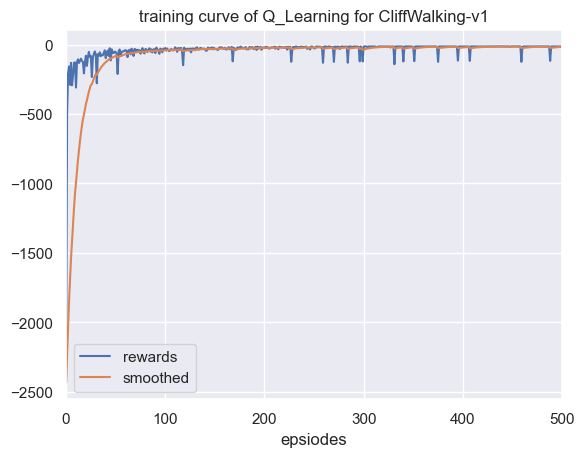

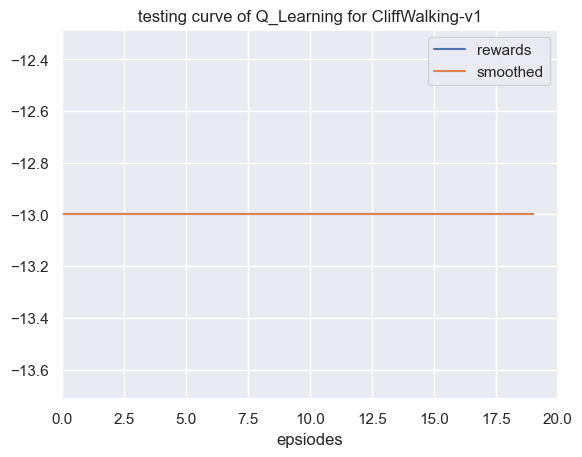

In [93]:
# 参数
cfg = Config()
# 训练
env, agent = env_agent_config(cfg)
res_dic = train_Qlearning(cfg, env, agent)

plot_rewards(res_dic['rewards'], title=f"training curve of {cfg.algo_name} for {cfg.env_name}")
# 测试
res_dic = test(cfg, env, agent)

plot_rewards(res_dic['rewards'], title=f"testing curve of {cfg.algo_name} for {cfg.env_name}")  # 画出结果